Task 1

In [71]:
import numpy as np

def init_q_table(n_states, n_actions):
    return np.zeros((n_states, n_actions))

def q_update(Q, s, a, r, s_next, alpha, gamma):
    max_q_next = np.max(Q[s_next])
    Q[s,a] = Q[s,a]+alpha * (r + gamma* max_q_next - Q[s,a])
    return Q

Task 2

In [72]:
import matplotlib.pyplot as plt

def init_q_table(n_states, n_actions):
    return np.zeros((n_states, n_actions))

def q_update(Q, s, a, r, s_next, alpha, gamma):
    max_q_next = np.max(Q[s_next])
    Q[s, a] = Q[s, a] + alpha * (r + gamma * max_q_next - Q[s, a])
    return Q

class GridWorld:
    def __init__(self):
        self.size = 4
        self.n_states = 16
        self.terminal_states = [14, 15]
        self.reward_grid = np.array([
            [-1, -1, -1, -1],
            [-1, -1, -1, -1],
            [-1, -1, -1, -1],
            [-1, -1, -10, +10]
        ])
        self.state = 0

    def reset(self):
        self.state = 0
        return self.state

    def step(self, action):
        row = self.state // 4
        col = self.state % 4

        if action == 'up' and row > 0: row -= 1 
        elif action == 'down' and row < 3: row += 1
        elif action == 'left' and col > 0: col -= 1 
        elif action == 'right' and col < 3: col += 1

        next_state = 4 * row + col
        reward = self.reward_grid[row, col]
        done = next_state in self.terminal_states

        self.state = next_state
        return next_state, reward, done

def select_action(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    return np.argmax(Q[state])




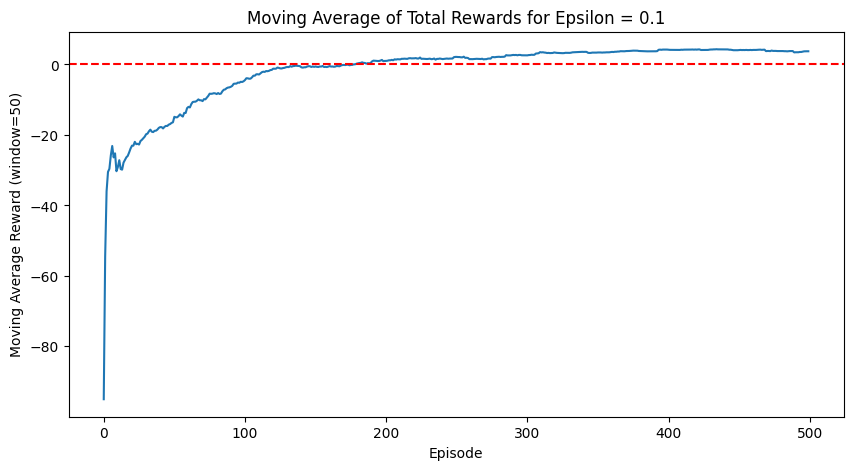

In [73]:
env = GridWorld()
n_actions = 4
actions = ['up', 'down', 'left', 'right']
Q = init_q_table(env.n_states, n_actions)

alpha = 0.01
gamma = 0.9
epsilon = 0.1
episodes = 500

total_rewards = []

for ep in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action_idx = select_action(Q, state, epsilon)
        action = actions[action_idx]
        next_state, reward, done = env.step(action)
        Q = q_update(Q, state, action_idx, reward, next_state, alpha, gamma)
        state = next_state
        total_reward += reward
    total_rewards.append(total_reward)

# Plot moving average
window = 50
moving_avg1 = [np.mean(total_rewards[max(0, i-window+1):i+1]) for i in range(len(total_rewards))]

plt.figure(figsize=(10,5))
plt.plot(moving_avg1)
plt.xlabel('Episode')
plt.ylabel('Moving Average Reward (window=50)')
plt.title('Moving Average of Total Rewards for Epsilon = 0.1')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Line')
plt.show()

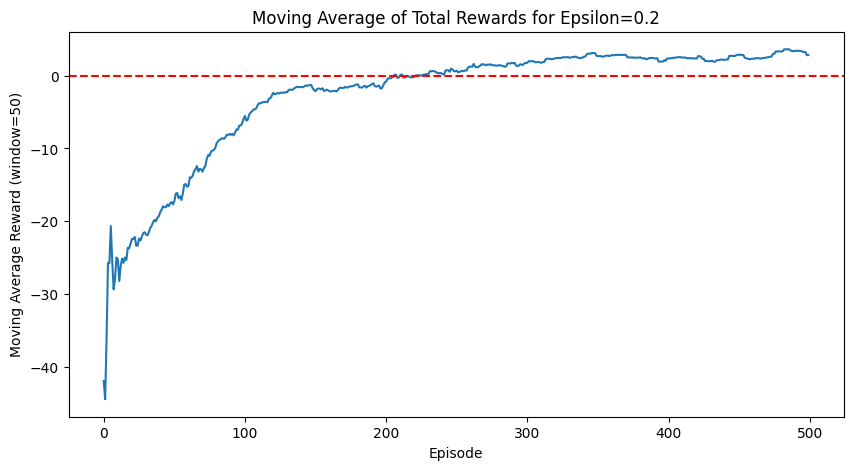

In [74]:
env = GridWorld()
n_actions = 4
actions = ['up', 'down', 'left', 'right']
Q = init_q_table(env.n_states, n_actions)

alpha = 0.01
gamma = 0.9
epsilon = 0.2
episodes = 500

total_rewards2 = []

for ep in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action_idx = select_action(Q, state, epsilon)
        action = actions[action_idx]
        next_state, reward, done = env.step(action)
        Q = q_update(Q, state, action_idx, reward, next_state, alpha, gamma)
        state = next_state
        total_reward += reward
    total_rewards2.append(total_reward)

# Plot moving average
window = 50
moving_avg2 = [np.mean(total_rewards2[max(0, i-window+1):i+1]) for i in range(len(total_rewards))]

plt.figure(figsize=(10,5))
plt.plot(moving_avg2)
plt.xlabel('Episode')
plt.ylabel('Moving Average Reward (window=50)')
plt.title('Moving Average of Total Rewards for Epsilon=0.2')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Line')
plt.show()

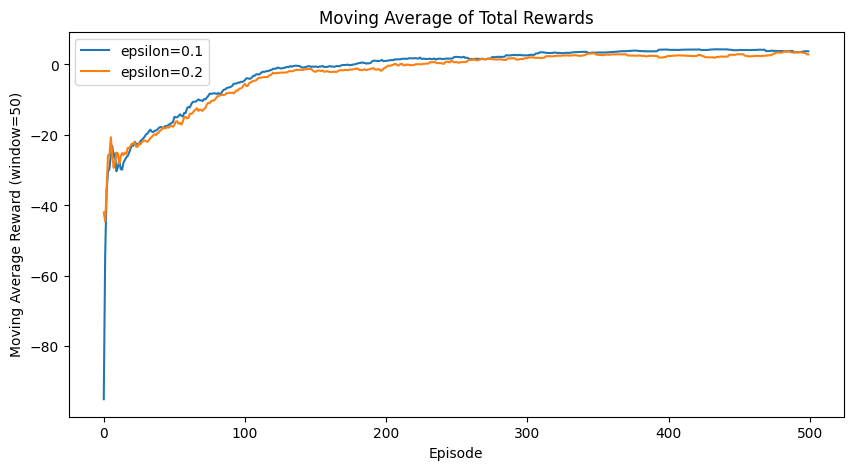

In [75]:
plt.figure(figsize=(10,5))
plt.plot(moving_avg1, label='epsilon=0.1')
plt.plot(moving_avg2, label='epsilon=0.2')
plt.xlabel('Episode')
plt.ylabel('Moving Average Reward (window=50)')
plt.title('Moving Average of Total Rewards')
plt.legend()
plt.show()

The plot for epsilon=0.2 is mostly lower than epsilon=0.1 until a given number of episodes. This shows that the model learns s bit slower with larger epsilon.

Task 3

In [76]:
import random
from collections import deque
        
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        return (np.array(x) for x in zip(*transitions))
    def __len__(self):
        return len(self.buffer)

In [77]:
buffer = ReplayBuffer(100)  

for _ in range(100):
    state = np.random.randint(0, 10)     
    action = np.random.randint(0, 4)      
    reward = np.random.random()           
    next_state = np.random.randint(0, 10) 
    done = np.random.choice([True, False])
    buffer.push(state, action, reward, next_state, done) 

states, actions, rewards, next_states, dones = buffer.sample(32)  

print("Shapes:", [arr.shape for arr in (states, actions, rewards, next_states, dones)])
print("Data types:", [arr.dtype for arr in (states, actions, rewards, next_states, dones)])


Shapes: [(32,), (32,), (32,), (32,), (32,)]
Data types: [dtype('int64'), dtype('int64'), dtype('float64'), dtype('int64'), dtype('bool')]


In [78]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQNPolicy(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(DQNPolicy, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),  
            nn.ReLU(),               
            nn.Linear(128, 128),    
            nn.ReLU(),
            nn.Linear(128, action_dim) 
        )

    def forward(self, x):
        return self.net(x)  

class DQNTarget(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(DQNTarget, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())


Episode 0, Reward: 15.0, ε: 1.000
Episode 10, Reward: 23.0, ε: 0.950
Episode 20, Reward: 17.0, ε: 0.900
Episode 30, Reward: 16.0, ε: 0.850
Episode 40, Reward: 46.0, ε: 0.800
Episode 50, Reward: 41.0, ε: 0.750
Episode 60, Reward: 14.0, ε: 0.700
Episode 70, Reward: 41.0, ε: 0.650
Episode 80, Reward: 17.0, ε: 0.600
Episode 90, Reward: 22.0, ε: 0.550
Episode 100, Reward: 71.0, ε: 0.500
Episode 110, Reward: 80.0, ε: 0.450
Episode 120, Reward: 88.0, ε: 0.400
Episode 130, Reward: 125.0, ε: 0.350
Episode 140, Reward: 83.0, ε: 0.300
Episode 150, Reward: 128.0, ε: 0.250
Episode 160, Reward: 188.0, ε: 0.200
Episode 170, Reward: 112.0, ε: 0.150
Episode 180, Reward: 154.0, ε: 0.100
Episode 190, Reward: 20.0, ε: 0.050
Episode 200, Reward: 128.0, ε: 0.010
Episode 210, Reward: 124.0, ε: 0.010
Episode 220, Reward: 148.0, ε: 0.010
Episode 230, Reward: 140.0, ε: 0.010
Episode 240, Reward: 171.0, ε: 0.010
Episode 250, Reward: 350.0, ε: 0.010
Episode 260, Reward: 169.0, ε: 0.010
Episode 270, Reward: 235.0,

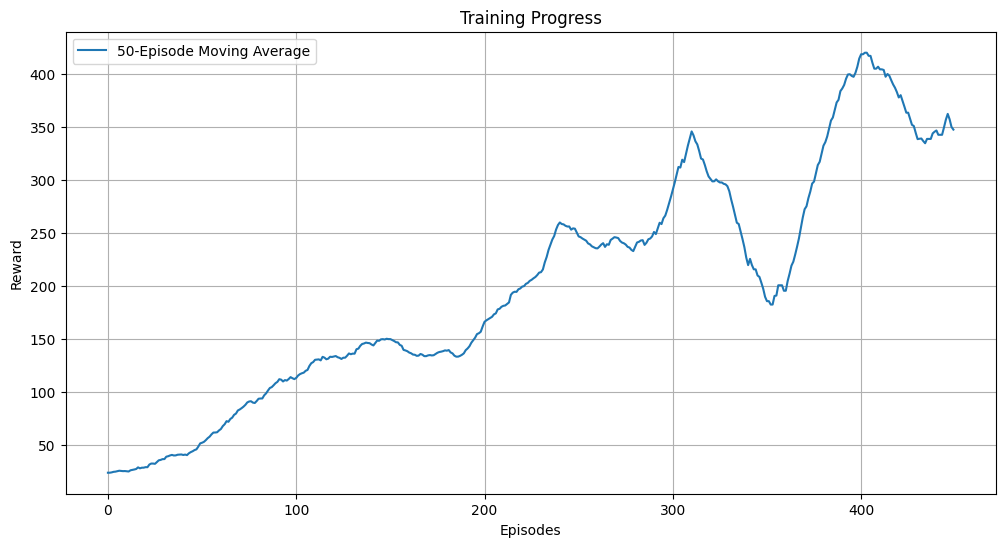

Success Rate (last 100 episodes): 91.00%


In [79]:
import gymnasium as gym
import matplotlib.pyplot as plt

N = 500        # Total episodes 
M = 200        # epsilon decay rate
X = 10         # Target network update frequency
γ = 0.99       # Discount factor
batch_size = 32
replay_capacity = 10000
min_replay_size = 500

# Environment setup
env = gym.make('CartPole-v1')
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# DQN Network
class DQNPolicy(torch.nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(obs_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, action_dim)
        )
    def forward(self, x):
        return self.net(x)

# Replay Buffer

# Initialize networks and optimizer
policy_net = DQNPolicy(obs_dim, action_dim).to(device)
target_net = DQNPolicy(obs_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

replay_buffer = ReplayBuffer(replay_capacity)

# Training metrics
episode_rewards = []
moving_avg = []

for episode in range(N):
    state, _ = env.reset()
    total_reward = 0
    done = False

    # Linear ε decay
    ε = max(0.01, 1.0 - episode/M)

    while not done:
        # ε-greedy action selection
        if np.random.random() < ε:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                action = policy_net(state_tensor).argmax().item()

        # Environment step
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        # Store transition
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state

        # Start training when buffer has enough samples
        if len(replay_buffer) >= min_replay_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            states = torch.FloatTensor(states).to(device)
            actions = torch.LongTensor(actions).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            next_states = torch.FloatTensor(next_states).to(device)
            dones = torch.BoolTensor(dones).to(device)

            # Compute target Q-values
            with torch.no_grad():
                next_q_values = target_net(next_states).max(1)[0]
                targets = rewards + γ * next_q_values * (~dones)

            # Compute current Q-values
            current_q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

            # Compute loss
            loss = loss_fn(current_q_values, targets)

            # Optimize model
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
            optimizer.step()

    # Update target network
    if episode % X == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Store metrics
    episode_rewards.append(total_reward)

    # Update moving average
    if episode >= 50:
        avg = np.mean(episode_rewards[-50:])
        moving_avg.append(avg)

    # Print progress
    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {total_reward}, ε: {ε:.3f}")

# Plotting
plt.figure(figsize=(12,6))
plt.plot(moving_avg, label='50-Episode Moving Average')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Training Progress')
plt.legend()
plt.grid(True)
plt.show()

# Success rate calculation
success_rate = np.mean([r >= 195 for r in episode_rewards[-100:]]) * 100
print(f"Success Rate (last 100 episodes): {success_rate:.2f}%")

env.close()